# TMLE Walkthrough
This notebook walks through how the targeted maximum likelihood estimation method works for inferring causal parameters from data.  
  
This is all based on a worked example given in: *Luque-Fernandez MA, Schomaker M, Rachet B, Schnitzer ME. Targeted maximum likelihood estimation for a binary treatment: A tutorial. Statistics in Medicine. 2018; 37: 2530–2546. https://doi.org/10.1002/sim.7628*

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf # allows R-like syntax 

import matplotlib.pyplot as plt

from scipy.special import expit 

from tmle import targeting_step
from tutorial import generate_data, produce_dag

### Data Generating Function
  
Causal ML is about inferring parameters of some data generating function.
  
A key element is the DAG, we work off the following DAG (taken directly from the paper). This DAG is intended to simulate the causal pathway for mortality from cancer treatment 
  
We then generate date based on that DAG:
- `W1` ('sex') and `W2` ('age category') are generated as Bernoulli variables with probabibility 0.5 and 0.65 respectively 
- `W3` ('cancer stage') and `W4` ('comorbidities') are generated as ordinal variables with 4 and 5 levels respectively. The value for each is generated as a random uniform distribution and the values are rounded off to the closest integer
- `A` ('treatment variable') and `Y` ('outcome variable') are generated as binary indicators using a log-linear model. In the treatment and outcome models, there is an interaction term between `W2` and `W4` based on e.g. 'increased risk of comorbidities among older adults' 

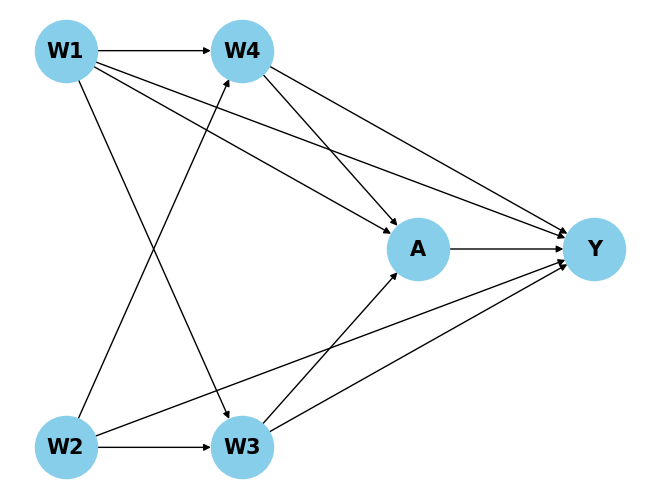

In [2]:
fig = produce_dag()
plt.show()

In [3]:
df = generate_data(2000000, 555) # generate a huge dataset from which we can calculate the 'true' ATE

true_EY1 = df['Y1'].mean()
true_EY0 = df['Y0'].mean()
true_ATE = true_EY1-true_EY0
print(f'True ATE = {true_ATE}')

True ATE = 0.19324049999999993


In [4]:
# now generate a much smaller dataset that we will actually use for our methods
df = generate_data(10000, 556)
df

,w1,w2,w3,w4,A,Y,Y1,Y0
0,1.0,1.0,3.380,2.750,0.0,1.0,0.0,1.0
1,0.0,0.0,3.994,3.031,0.0,1.0,1.0,1.0
2,1.0,1.0,0.040,4.536,1.0,1.0,1.0,1.0
3,1.0,0.0,2.001,3.052,0.0,1.0,1.0,1.0
4,0.0,0.0,0.007,4.160,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
9995,0.0,1.0,1.777,2.746,0.0,1.0,1.0,1.0
9996,1.0,1.0,0.777,4.488,1.0,1.0,1.0,1.0
9997,1.0,1.0,1.428,2.478,0.0,0.0,1.0,0.0
9998,0.0,1.0,1.843,1.945,0.0,1.0,0.0,1.0


## Outcome Model

The first step of TMLE is to define an outcome model. This is a model which predicts $E(Y | A, \vec{W})$, where $Y$ is the outcome variable $A$ is the treatment variable and $\vec{W}$ is the vector of covariates. We're going to assume that $Y$ and $A$ are binary variables here, but this can be generalised to the continuous case as well  
  
As stated, the outcome model predicts the expected value of the outcome given the values for the treatment variable and covariates. It can be thought of as:  
$$
Q(A, \vec{W}) = E(Y | A, \vec{W})
$$
  
A big issue with causal inference is specifying the form of this model incorrectly (e.g. assuming that it will be a logistic regression). ML approaches are great for coming up with 'data-adaptive' models that can capture more complicated features in the data.  
  
That said, in this notebook I'm just going to assume a binary logistic regression model for simplicity. I know this is wrong (because the data generating function has higher order interaction terms)

In [5]:
# this is the outcome model, fit a binary logistic regression for it 
model = smf.logit("Y ~ A + w1 + w2 + w3 + w4", data=df)
model = model.fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.607563
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Thu, 21 Nov 2024   Pseudo R-squ.:                 0.08721
Time:                        17:14:18   Log-Likelihood:                -6075.6
converged:                       True   LL-Null:                       -6656.1
Covariance Type:            nonrobust   LLR p-value:                8.525e-249
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1873      0.070    -16.972      0.000      -1.324      -1.050
A              0.8134      0.

We now use that outcome model to calculate predicted outcomes for three situations:  
- what the expected outcomes are from this model in the actual situation of our dataset, using the $A$ and $\vec{W}$ values for each patient, i.e. $$\hat{Q}(A, \vec{W})$$
- what the expected outcomes are from this model in a counterfactual where every patient in the population received the treatment i.e. $$\hat{Q}(1, \vec{W})$$
- what the expected outcomes are from this model in a counterfactual where every patient in the population did not receive the treatment i.e. $$\hat{Q}(0, \vec{W})$$

In [6]:
# we create a new dataset where the treatment variables are set to 1 and 0 

newdata_A1 = df.copy()
newdata_A1['A'] = 1

newdata_A0 = df.copy()
newdata_A0['A'] = 0

# predict probabilities based on this data 
QAW = model.predict(df) # what does our model predict the outcome as (probability)
Q1W = model.predict(newdata_A1) # what if the patient had been treated
Q0W = model.predict(newdata_A0) # what if the patient had not been treated


We can use these predictions to calculate an initial estimate for the average treatment effect based on this outcome model.  
  
The average treatment effect is:
$$
\Psi = \mathrm{ATE} = E_W\bigg[E\big[Y|A=1, \vec{W}\big]-E\big[Y|A=0, \vec{W}\big]\bigg]
$$
This is the mean difference in outcomes across the population between two counterfactuals: one where every patient received the treatment and one where every patient received the control/did not receive the treatment.  

In our case, the G-computation estimate of the ATE is given by:
$$
\hat{\Psi}_{G-comp} = \frac{1}{N} \sum_{i=1}^N \bigg[ \hat{Q}(1, \vec{W}_i) - \hat{Q}(1, \vec{W}_i) \bigg]
$$
where the sum is over the $N$ members of the population and the index $i$ refers to the covariates of person $i$
  
*N.B. We are using TMLE to calculate the ATE, but it's really just a general estimation process and you can use it to estimate other quantities too, that will change the later targeting step*

In [7]:

# initial ATE estimate: 
init_ATE_est = Q1W.mean() - Q0W.mean() # difference in outcome if every patient treated vs every patient not treated
print(f'Initial (biased) ATE estimate = {init_ATE_est}')

Initial (biased) ATE estimate = 0.16147770596532363


## Treatment Model
  
The next stage is to build a model that predicts how likely every patient in the population is to be treated.  
  
This is also known as the propensity score.  
  
Using the same notation as above, this model gives:
$$
g(\vec{W}) = \mathrm{Pr}(A=1 | \vec{W})
$$  
  
Again, this would be best as a ML model! But here we're going to use another binary logistic regression

In [8]:
# this is the treatment model (propensity score) 
ps_model = smf.logit("A ~ w1 + w2 + w3 + w4", data=df)
ps_model = ps_model.fit()
print(ps_model.summary())


Optimization terminated successfully.
         Current function value: 0.335604
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      A   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Thu, 21 Nov 2024   Pseudo R-squ.:                  0.2144
Time:                        17:14:18   Log-Likelihood:                -3356.0
converged:                       True   LL-Null:                       -4271.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8512      0.143    -40.835      0.000      -6.132      -5.570
w1            -0.0393      0.

We then use that model to calculate a propensity score for every patient in our population

In [9]:

# use this model to calculate propensity scores 
gW = ps_model.predict(df)

We use the propensity score to calculate three quantities: 
- The inverse probability of receiving treatment: $$H(1, \vec{W}) = \dfrac{1}{g(\vec{W})}=\dfrac{1}{\mathrm{Pr}(A=1|\vec{W})}$$
- The negative inverse probability of receiving treatment: $$H(0, \vec{W}) = -\dfrac{1}{1-g(\vec{W})}=-\dfrac{1}{\mathrm{Pr}(A=0|\vec{W})}$$
- The 'clever covariate' which is the the inverse probability of receiving treatment if the subject was treated and the negative inverse probability of receiving treatment if the subject was not treated:
$$
H(A, \vec{W}) = \dfrac{I(A=1)}{\mathrm{Pr}(A=1|\vec{W})} - \dfrac{I(A=0)}{\mathrm{Pr}(A=0|\vec{W})}
$$

## 3) Targeting Step  
  
There are issues with using ML models to define the above two models; they do not have the correct asymptotic properties for inference. That is to say that they do not converge to some "true" value as we add more data, they may just change the model. The models are also designed to optimise the bias-variance tradeoff for the quantity they are calculating, but we actually want to optimise the bias-variance tradeoff for the parameter of interest (that is our estimated value for the ATE).  
  
The "magic" step of TMLE is the "targeting step" which uses the treatment model to correct the outcome model to produce an overall model which is aymptotically unbiased for calculating the ATE.  
  
This step is designed for the ATE and would differ for other quantities.  
  
The reason we do any of this is "non-parametric theory"... complicated, not really sure why it works (but it does because that is how the model was derived)  
  
The point of the targeting step is to solve an *estimating equation* for the *efficient influence function* (EIF) of our estimand of interest  


No explanation of why this works, but we are going to use this relationship:
$$
\mathrm{logit}(E[Y|A, \vec{W}]) = \mathrm{logit}(\hat{E}[Y|A, \vec{W}]) + \epsilon H(A, \vec{W})
$$

This is essentially a logistic regression. However, the 'intercept' in our logistic regression $\mathrm{logit}(\hat{E}[Y|A, \vec{W}])$ is not a constant value, but instead a vector of values. We can see it as an 'offset' or 'fixed intercept' in a logistic regression, rather than a constant-value intercept.  
  
To accomplish the goal of solving an estimating equation for the EIF comes down to fitting a logistic regression with one covariate $H(A,\vec{W})$ and the initial outcome estimate $\mathrm{logit}(\hat{E}[Y|A, \vec{W}])$ as a fixed intercept. The outcome of the logistic regression is the observed outcome $Y$.  
  
This gives a value for the parameter $\epsilon$, which we call a "fluctuation parameter" because it provides information about how much to change our initial outcome estimates and $H(A, \vec{W})$ is the "clever covariate" because it cleverly helps solve for the EIF and update estimates

In [10]:
target_model = targeting_step(df, gW, QAW) # carries out the targeting step to optimise the b-v tradeoff for the ATE
epsilon = target_model.params # coefficients in this targeting step

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6074.6
Date:                Thu, 21 Nov 2024   Deviance:                       12149.
Time:                        17:14:18   Pearson chi2:                 1.00e+04
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0001960
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
H0W            0.0031      0.019      0.161      0.8

Once we have that value for $\epsilon$, we can update the expected outcomes of all observations:  
$$
\hat{E}^*[Y|A, \vec{W}] = \mathrm{expit} \bigg( \mathrm{logit}(\hat{E}[Y|A, \vec{W}]) + \epsilon H(A, \vec{W}) \bigg)
$$
and the outcomes of the counterfactuals as well  
$$
\hat{E}^*[Y|A=1, \vec{W}] = \mathrm{expit} \bigg( \mathrm{logit}(\hat{E}[Y|A=1, \vec{W}]) + \epsilon H(1, \vec{W}) \bigg)
$$

$$
\hat{E}^*[Y|A=0, \vec{W}] = \mathrm{expit} \bigg( \mathrm{logit}(\hat{E}[Y|A=0, \vec{W}]) + \epsilon H(0, \vec{W}) \bigg)
$$

In [11]:
# use the epsilon values to improve the treatment model

# Convert Q0W and Q1W to logit scale and update them
logit_Q0W = np.log(Q0W / (1 - Q0W))
logit_Q1W = np.log(Q1W / (1 - Q1W))

# Update logit values with epsilon adjustments
logit_Q0W_1 = logit_Q0W + epsilon['H0W'] / (1 - gW)
logit_Q1W_1 = logit_Q1W + epsilon['H1W'] / gW

# Convert back to probabilities using inverse-logit
Q0W_1 = expit(logit_Q0W_1)
Q1W_1 = expit(logit_Q1W_1)

Which means we can finally calculate our TMLE estimate of the ATE:  
$$
\hat{\Psi}_{TMLE} = \frac{1}{N}\sum_{i=1}^N \bigg[ \hat{E}^*[Y_i|A=1, \vec{W}_i] - \hat{E}^*[Y_i|A=0, \vec{W}_i] \bigg]
$$

In [12]:
# Now we can calculate an improved ATE
EY1_tmle_1 = Q1W_1.mean()
EY0_tmle_1 = Q0W_1.mean()
ATE_tmle_1 = EY1_tmle_1 - EY0_tmle_1

In [13]:
# combine all of this info into a new table 
new_df = pd.DataFrame({
    'Q0W': Q0W,
    'Q1W': Q1W,
    'gW': gW,
    'Q0W_1': Q0W_1,
    'Q1W_1': Q1W_1,
    'Treatment_Effect': Q1W_1 - Q0W_1
})

# Set the index of the new DataFrame to match the index of the original df (patient id)
new_df.index = df.index

final_df = df.join(new_df, how='inner') # dataframes are joined on index

final_df

,w1,w2,w3,w4,A,Y,Y1,Y0,Q0W,Q1W,gW,Q0W_1,Q1W_1,Treatment_Effect
0,1.0,1.0,3.380,2.750,0.0,1.0,0.0,1.0,0.734167,0.861670,0.202767,0.734931,0.864205,0.129274
1,0.0,0.0,3.994,3.031,0.0,1.0,1.0,1.0,0.666183,0.818220,0.091842,0.666947,0.825151,0.158204
2,1.0,1.0,0.040,4.536,1.0,1.0,1.0,1.0,0.656060,0.811403,0.377572,0.657192,0.813158,0.155966
3,1.0,0.0,2.001,3.052,0.0,1.0,1.0,1.0,0.490919,0.685041,0.060540,0.491750,0.700317,0.208567
4,0.0,0.0,0.007,4.160,0.0,1.0,0.0,1.0,0.492625,0.686512,0.104653,0.493498,0.695378,0.201881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1.0,1.777,2.746,0.0,1.0,1.0,1.0,0.693199,0.835962,0.157206,0.693987,0.839717,0.145730
9996,1.0,1.0,0.777,4.488,1.0,1.0,1.0,1.0,0.695004,0.837124,0.405263,0.696116,0.838581,0.142464
9997,1.0,1.0,1.428,2.478,0.0,0.0,1.0,0.0,0.606817,0.776835,0.115846,0.607660,0.783270,0.175610
9998,0.0,1.0,1.843,1.945,0.0,1.0,0.0,1.0,0.647863,0.805812,0.084869,0.648642,0.813699,0.165057


In [14]:
# compare ATE estimate (corrected) to naive ATE and true estimate
print("="*50)
print(f'Initial (uncorrected) ATE estimate = {init_ATE_est}')
print(f'Absolute bias (from true value) = {abs(init_ATE_est-true_ATE)}')
print(f'Percentage bias (from true value) = {abs(init_ATE_est-true_ATE)*100/true_ATE}%')
print("="*50)
print(f'Corrected (by TMLE) ATE estimate = {ATE_tmle_1}')
print(f'Absolute bias (from true value) = {abs(ATE_tmle_1-true_ATE)}')
print(f'Percentage bias (from true value) = {abs(ATE_tmle_1-true_ATE)*100/true_ATE}%')
print("="*50)

Initial (uncorrected) ATE estimate = 0.16147770596532363
Absolute bias (from true value) = 0.0317627940346763
Percentage bias (from true value) = 16.43692395469703%
Corrected (by TMLE) ATE estimate = 0.18631804269111385
Absolute bias (from true value) = 0.006922457308886076
Percentage bias (from true value) = 3.5823014890181297%


And you can see that even though both the treatment and outcome models are actually specified incorrectly, TMLE still manages to reduce the bias and get us closer to the true ATE value

## 4) Calculating standard errors
  
Once all that is done, we can calculate standard errors. This is another benefit of using the targeting step. To find them, we need to compute the *influence function* (IF) wgucg us essentially a function that defines how much each observation influences the final estimate.  
  
It is given by: 
$$
\hat{IF} = \bigg( Y - \hat{E}^*(Y|A, \vec{W})\bigg) H(A, \vec{W}) + \hat{E}^*(Y|A=1,\vec{W}) - \hat{E}^*(Y|A=0,\vec{W}) - \hat{\Psi}_{TMLE}
$$

Once you have it, the standard error of our estimate is given by:
$$
\hat{\sigma} = \sqrt{\dfrac{\mathrm{var}(\hat{IF})}{N}}
$$

Note that a TMLE estimator is asymptotically normally distributed

In [23]:
d1 = (df['A'] * (df['Y'] - Q1W_1)/gW) + Q1W_1 - EY1_tmle_1
d0 = ((1 - df['A']) * (df['Y'] - Q0W_1))/(1 - gW) + Q0W_1 - EY0_tmle_1
infl_curve = d1 - d0
n = df['Y'].count()

In [24]:
std_err_tmle = np.sqrt(np.var(infl_curve)/n)
tmle_lower_conf = ATE_tmle_1 - 1.96*std_err_tmle
tmle_upper_conf = ATE_tmle_1 + 1.96*std_err_tmle

In [26]:
print(f"ATE = {ATE_tmle_1} (95% CI: {tmle_lower_conf}, {tmle_upper_conf})")

ATE = 0.18631804269111385 (95% CI: 0.1270185551046911, 0.2456175302775366)
